# CSCI 3352 Biological Networks, Spring 2020, Prof. Clauset
Submit here: https://moodle.cs.colorado.edu/course/view.php?id=1273

# Problem Set 7 : Network epidemiology


***

**Name**: Denver Chernin <br/>
**Worked with**: Julia Sanford

***

This assignment is due on Moodle by **11:55pm on Friday, March 13th**. Your solutions to non-programming questions should be done in Markdown directly below the associated question. Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own** (see syllabus for detailed guidance). There are 65 points total, and 20 pts extra credit.

**NOTES**: 

- Unless a url is given for a data set, you will find the required data on the course Moodle.
- If you're not familiar with typesetting math directly in Markdown, you may do your work on paper first and then typeset it later. This [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) provides helpful guidance for writing math in Markdown. 
- It is **unhelpful** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code.

***
* [Documentation for networkx](https://networkx.github.io/documentation/stable/)

[//]: <> (Documentation for igraph Python https://igraph.org/python/ )

In [1]:
import networkx as nx
import numpy as np
import copy
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline
import random as rnd
rnd.seed()

In [2]:
def drawGz(G,z):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws G with node labels from partition z
    #
    # input  : G is a networkx graph
    #        : z is a dictionary of group labels for G's nodes
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    colors = ['#d61111','#11d646','#11c6d6','#d67711','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)
    
    node_colors = []
    for i in G.nodes():
        if z[i]=='S':
            cid = 0
        if z[i]=='I':
            cid = 1
        if z[i]=='R':
            cid = 2
        node_colors.append(colors[int(cid)])
    nsize  = 600
    flabel = True

    if G.order() > 50:
        nsize  = 100
        flabel = False
    
    nx.draw_kamada_kawai(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it prettier
    #nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

In [3]:
def plot_epidemicDynamics(St,It,Rt):
    # DO NOT MODIFY THIS FUNCTION
    # This function plots the S(t),I(t),R(t) time series nicely
    # WARNING: function is optimistic: assumes inputs are properly formatted

    fig = plt.figure()
    ax1 = fig.add_subplot(111) # put multiple 
    plt.plot(range(len(St)), St, 'bo-', alpha=0.5,label='S(t)')  # plot the S(t) time series
    plt.plot(range(len(It)), It, 'rv-', alpha=0.5,label='I(t)')  # plot the I(t) time series
    plt.plot(range(len(Rt)), Rt, 'gs-', alpha=0.5,label='R(t)')  # plot the R(t) time series
    plt.ylabel('number of nodes')
    plt.xlabel('time, t')
    plt.legend(loc='upper right');
    #ax1.set_xlim([0, 50])
    plt.show()
    return

***
## Part 1 (10 pts) : Warming up

* Using the SIR simulation code from the in-class lab, write a function `run_SIR(G,s,beta,gmma,flag)` that
  * takes as input a simple `networkx` graph, an integer `s` that specifies the _number_ of randomly chosen infected nodes at time $t=0$, choices of $\beta$ and $\gamma$, and a binary variable `flag` (`=0` means run silently; `=1` means display any intermediate outputs, like `drawGz()` or `print()` statements),
  * runs the simulation to its completion, and then
  * returns the $S(t)$, $I(t)$, $R(t)$ time series for the progression of the epidemic (for plotting using the `plot_epidemicDynamics()` function) _and_ a dictionary `xt` that stores for each node `i` the corresponding time `t` at which `i` became infected. You'll need to instrument the existing simulation code to track `xt` correctly.
  
* Then, apply your new function to the toy graph from the lecture notes and lab, with $s=1$ and $\beta=\gamma=0.3$, and plot the resulting time series.

In [203]:
def run_SIR(G,s,beta,gmma,flag):
    #Create labels for each node
    nodes = list(G.nodes())
    xt = {}
    for n in nodes:
        xt[n] = 0
    zt = {}
    
    #Pick random s nodes to infect, rest are susceptible
    infect = np.random.choice(nodes, s)
    for n in nodes:
        if(n in infect):
            zt[n] = 'I'
            xt[n] = 1
        else:
            zt[n] = 'S'
    #initialize lists for each category
    St = []
    Rt = []
    It = []
    t = 1
    
    Sc,Ic,Rc = n-1,1,0 
    if(flag):
        print(f'time step {t}')
        drawGz(G,zt)
    #While people are infected
    while any(xi == 'I' for xi in zt.values()):
        zu = copy.deepcopy(zt) # nodes states for next time step (synchronous updates)

        # do S -> I transitions
        for e in G.edges():
            i,j = e[0],e[1]           # this edge (i,j)
            if zt[i]=='I' and zt[j]=='S' and zu[j]!='I':
                if rnd.random() < beta:
                    zu[j] = 'I'       # i infects j for next round
                    Sc,Ic = Sc-1,Ic+1 # update counts
                    xt[j] = t #mark when node j gets infected

            if zt[i]=='S' and zt[j]=='I' and zu[i]!='I':
                if rnd.random() < beta:
                    zu[i] = 'I'       # j infects i for next round
                    Sc,Ic = Sc-1,Ic+1 # update counts
                    xt[i] = t #mark when node i gets infected

        # do I -> R transitions
        for i in G.nodes():
            if zt[i] == 'I' and rnd.random() < gmma:
                zu[i] = 'R'           # i recovers (R)
                Ic,Rc = Ic-1,Rc+1     # update counts

        # update all states synchronously, update clock
        zt = copy.deepcopy(zu)
        t  = t+1
        if(flag):
            print(f'time step {t}')
            drawGz(G,zt)

        St.append(Sc)
        It.append(Ic)
        Rt.append(Rc) # append these counts to the time series
    
    return St,It,Rt,xt

time step 1


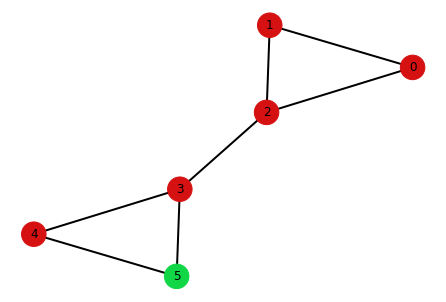

time step 2


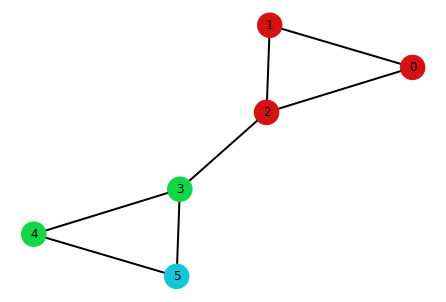

time step 3


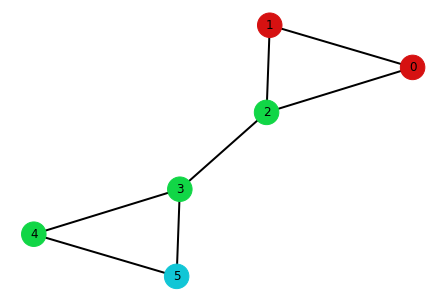

time step 4


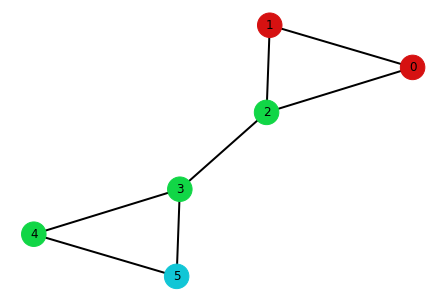

time step 5


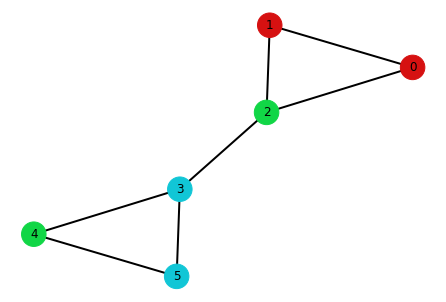

time step 6


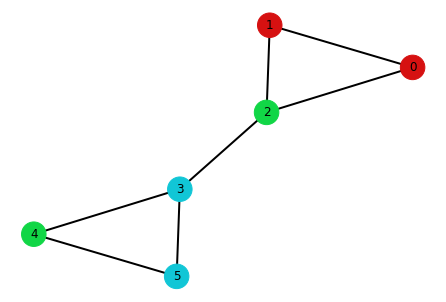

time step 7


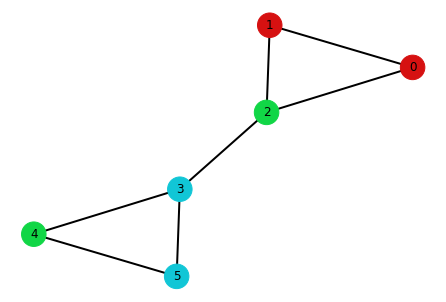

time step 8


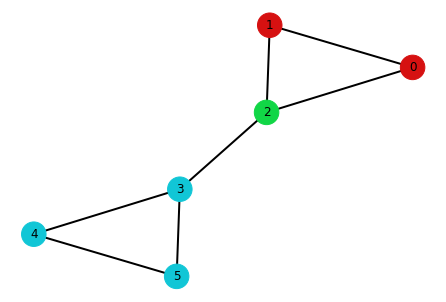

time step 9


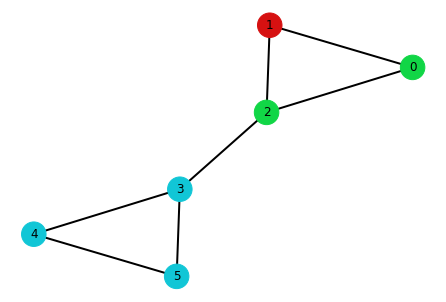

time step 10


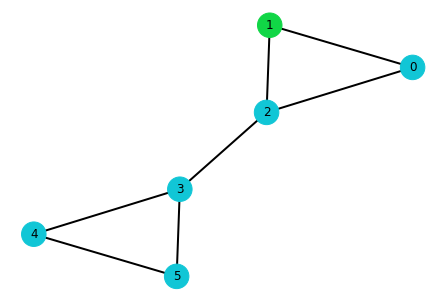

time step 11


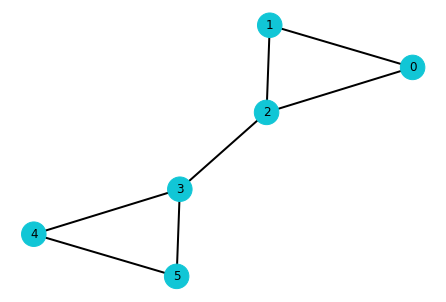

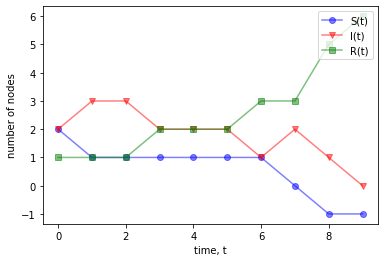

{0: 8, 1: 9, 2: 2, 3: 1, 4: 1, 5: 1}


In [204]:
##### do not modify below here #####
##    run this code once you've written the run_SIR() function

G  = nx.Graph([(0,1),(0,2),(1,2),(2,3),(3,4),(3,5),(4,5)]) # a simple graph G

beta = 0.3
gmma = 0.3
flag = 1

St,It,Rt,xt = run_SIR(G,1,beta,gmma,flag)
plot_epidemicDynamics(St,It,Rt)
print(xt)
##### do not modify above here #####

### Problem 2-A (20 pts)

In `Problem 2-B` we'll use the Chung-Lu model to generate random graphs with a specified degree distribution. However, to see how varying the degree structure changes the epidemic's shape, we'll first need a low-dimensional way to vary the degree structure's shape. There are many ways to do this. Here, we'll use a 2-parameter distribution called a *stretched exponential*, which has the form:

<br/>
<center>$\Pr(x) \propto x^{\beta-1} \textrm{exp}(-\lambda \, x^{\beta})$,</center>

where $\beta\geq 0$ and $\lambda\geq 0$. When $\beta=1$, this distribution returns a standard (low variance) exponential distribution with parameter $\lambda$; when $\beta=2$, it decays like a standard (lower variance) Gaussian or Normal distribution; and when $\beta<1$, it decays more slowly than an exponential (higher variance). The parameter $\lambda$ is inversely related to the mean degree, so that $\lambda<1$ means a higher mean, and $\lambda>1$ means a lower mean.

* Use the provided function `drawFrom_SE(n,beta,lmbda)` to generate *three* lists, each containing $n=1000$ values. The three lists should be generated with different combinations of $\beta$ and $\lambda$, and should meet the following criteria:
  * one distribution should have "low" variance, one should have "high" variance, and one should be in between those, and
  * they should all have the roughly the same average value (e.g., in my solutions, the mean is about $2.3\pm0.1$).
* Modify the `plot_2CCDF()` function from `Problem Set 2` to display all three of these distributions together, i.e., make and apply a function `plot_3CCDF()`.
* Briefly describe the effect of increasing or decreasing $\beta$ and $\lambda$ on the shape of the plotted distributions, e.g., on the shape of the "body" (the middle part) and the upper tail of the distribution.

Hint: You will likely need to fiddle with different choices of parameters in order to find good settings. Try starting at $\beta=\lambda=1$, and then increasing or decreasing one, then the other parameter, until you get something reasonable when you plot it. For the "high" variance distribution, you'll want the maximum value you generate to be no higher than 100 or so.

In [13]:
def drawFrom_SE(n,beta,lmbda):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws n values from a stretched exponential distribution with parameters beta,lambda
    # and then rounds them to integers for use as degrees. It returns these in a list x.

    xmin = 0.5  # minimum value 
    x    = [] # 
    for i in range(n):
        xi = int(round( (xmin**beta - (1/lmbda)*np.log(1-rnd.random()))**(1/beta) ))
        x.append(xi)

    return x

In [217]:
def plot_3CCDF(kis1,kis2,kis3):
    # input : three lists of degrees
    # output: one plot showing the CCDFs of the three degree distributions Pr(K>=k) for k>=1
    
    # YOUR CODE
    kis1_max = max(kis1)
    kis2_max = max(kis2)
    kis3_max = max(kis3)
    # histograms
    icounts, ibins = np.histogram(kis1, bins=[i for i in range(kis1_max+2)], density=True)
    icumcounts = np.cumsum(icounts)
    icumcounts = np.insert(icumcounts,0,0)
    ocounts, obins = np.histogram(kis2, bins=[i for i in range(kis2_max+2)], density=True)
    ocumcounts = np.cumsum(ocounts)
    ocumcounts = np.insert(ocumcounts,0,0)
    ucounts, ubins = np.histogram(kis3, bins=[i for i in range(kis3_max+2)], density=True)
    ucumcounts = np.cumsum(ucounts)
    ucumcounts = np.insert(ucumcounts,0,0)

    # plots
    fig = plt.figure()
    ax1 = fig.add_subplot(111) # put multiple 
    plt.loglog(ibins[1:-1], 1-icumcounts[1:-1], 'ro', alpha=0.5, label='kis1')
    plt.loglog(obins[1:-1], 1-ocumcounts[1:-1], 'bo', alpha=0.5, label='kis2')
    plt.loglog(ubins[1:-1], 1-ucumcounts[1:-1], 'yo', alpha=0.5, label='kis3')
    plt.title('CCDF, in- and out-degrees (loglog)')
    plt.xlabel('Degree, k')
    plt.ylabel('Pr(K>=k)')
    plt.legend(loc='upper right');
    plt.show()
    return


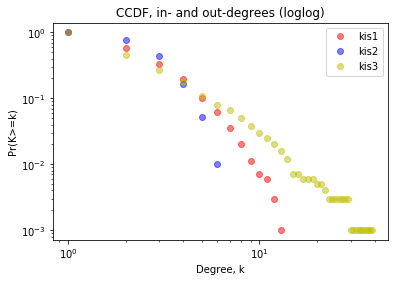

x1, mean = 2.355
x2, mean = 2.415
x3, mean = 2.406


In [218]:
#declare number of nodes
n = 1000

#defining beta and lambdas to create high/low
#variations of degrees for the n nodes
beta1 = 1 
lmbda1 = 0.55

beta2 = 2
lmbda2 = 0.15

beta3 = 0.5
lmbda3 = 1.5

##### do not modify below here #####
##    run this code once you've written the plot_3CCDF() function

x1 = drawFrom_SE(n,beta1,lmbda1)
x2 = drawFrom_SE(n,beta2,lmbda2)
x3 = drawFrom_SE(n,beta3,lmbda3)

plot_3CCDF(x1,x2,x3)

print(f'x1, mean = {sum(x1)/n}')
print(f'x2, mean = {sum(x2)/n}')
print(f'x3, mean = {sum(x3)/n}')

When variance is low such as in the red and blue curves from above you can see a sharper decline. This is because beta is larger than lambda create a small variance creating a smaller range of degrees. When lambda is larger than beta you see a more drawn out curve that reaches higher degrees.

### Problem 2-B (15 pts)

Now, using $\beta=\gamma=0.4$ (at the critical threshold of $R_0$):
* Use the built-in `networkx` Chung-Lu graph generator to make a graph for each of your three degree distributions.
* Then, run your SIR simulation on each graph, and plot the corresponding epidemic's dynamics.
* Discuss what you see as differences or similarities among or between the three cases, and offer an explanation _in terms of the role that node degree plays in spreading the epidemic_. Remember that the _only_ thing different about these three graphs is the degree structure. (You may find it useful to use `drawGz()` to visualize them.)

Hint: You may need to re-run the simulation on the same graphs multiple times in order to get three good runs (since each run will start the epidemic in a different location, and occasionally the epidemic may not take off). Alternatively, you can increase the number of initially infected nodes to a small integer (maybe 5 at most). When comparing epidemics, don't forget to look at how _long_ they last.

Normal


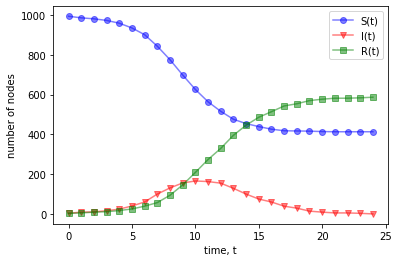

Low Variance


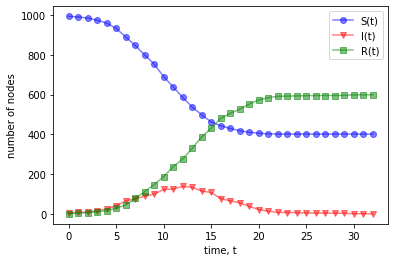

High Viarance


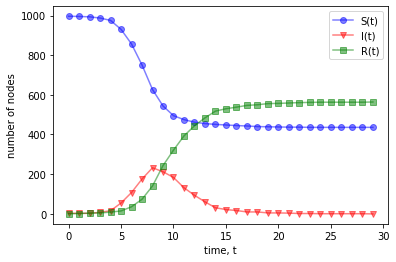

In [207]:
#define SIR params
beta = 0.4
gamma = 0.4 

#Create three chung-lu models
g1 = nx.expected_degree_graph(x1)
g2 = nx.expected_degree_graph(x2)
g3 = nx.expected_degree_graph(x3)

#Run simulation on each chung-lu model
#plot dynamics
St1,It1,Rt1,xt1 = run_SIR(g1, 2, beta, gamma, 0)
print("Normal")
plot_epidemicDynamics(St1,It1,Rt1)
print("Low Variance")
St2,It2,Rt2,xt2 = run_SIR(g2, 2, beta, gamma, 0)
plot_epidemicDynamics(St2,It2,Rt2)
print("High Viarance")
St3,It3,Rt3,xt3 = run_SIR(g3, 2, beta, gamma, 0)
plot_epidemicDynamics(St3,It3,Rt3)

- **beta = 1 & lambda = 0.55**
    - This is the top graph which has a standard low variance in its degree structure which means the degree structure is relatively similar for each node. This take 2nd longest for the epidemic to end (compared with multiple runs). It has the possibility to spread evenly as the degrees of the nodes are similar. The number of infected peaks early not heavily. Every node in the standard variance model has roughly the same degree and thus the spread will be even over the network. 
- **beta = 2 & lambda = 0.15**
    - The second graph/middle graph is for a lower variance of normally distributed degree structure. This is very similar to how society connections are represented. The infected peak is the lowest and more drawn out of any of our models as this also takes the longest for the epidemic to stop. 
- **beta = 0.5 & lambda 1.5**
    - The last graph is for a high variance degree structure which dies out the quickest, but peaks at the highest number of infected cases. This makes sense as some nodes have high degrees and thus have a higher chance of being infected or infecting others. In a high variance model, the node have wide ranges of degrees meaning it will spread faster through the network in some locations than others, it will die out when it reaches low degree areas. 

### Problem 2-C (20 pts)

High degree nodes, which are more common under high variance degree distributions, play a special role in epidemics. Let's investigate.
* Using the `xt` output variable from your `run_SIR()` function, make three scatter plots of the time of infection $t_i$ as a function of node degree $k_i$, one for each network.
* For each plot, calculate and report the correlation coefficient `r = np.corrcoef(x,y)[0,1]` between your $x$ and $y$ variables.
* Finally, discuss any patterns you see within and across your high/medium/low variance networks from this perspective, and use the correlation coefficients you calculate to offer an explanation (in terms of the network structure and the rules of the SIR epidemic) as to why that pattern exists.

Hint: Don't plot values where $t_i=-1$, which is a special value indicating that node $i$ was never infected.

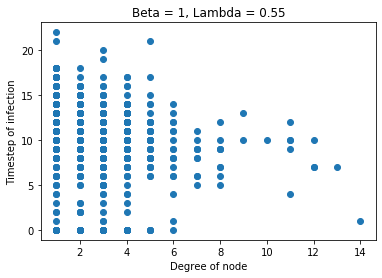

Correlation Coefficient: 0.24635190038567673


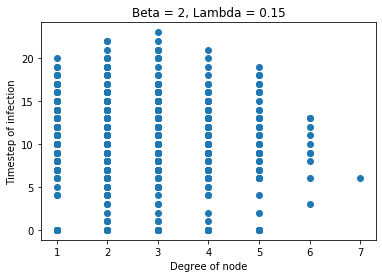

Correlation Coefficient: 0.24050648023483692


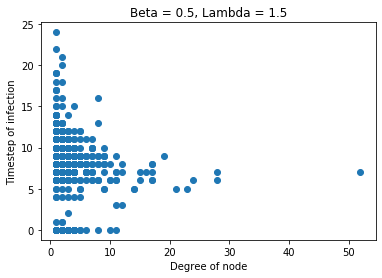

Correlation Coefficient: 0.15513678771313982


In [208]:
plt.title("Beta = 1, Lambda = 0.55")
plt.xlabel("Degree of node")
plt.ylabel("Timestep of infection")
#plotting the nodes versus when they were infected
plt.scatter(x1, xt1.values())
plt.show()
#calculating correlation coefficient
r = np.corrcoef(x1,list(xt1.values()))[0,1]
print(f"Correlation Coefficient: {r}")


plt.title("Beta = 2, Lambda = 0.15")
plt.xlabel("Degree of node")
plt.ylabel("Timestep of infection")
plt.scatter(x2, xt2.values())
plt.show()
r = np.corrcoef(x2,list(xt2.values()))[0,1]
print(f"Correlation Coefficient: {r}")


plt.title("Beta = 0.5, Lambda = 1.5")
plt.xlabel("Degree of node")
plt.ylabel("Timestep of infection")
plt.scatter(x3, xt3.values())
plt.show()
r = np.corrcoef(x3,list(xt3.values()))[0,1]
print(f"Correlation Coefficient: {r}")

Both low viariance models have more linear correlations than the higher variant. Trends of stacked nodes in the lower viarance models can be explained by if all nodes have similar degrees then all paths to and from a node roughly are the same length. At high variance the average distance to a node will be longer as some nodes will have high degrees and some with low degrees which is why it is more condensed.

***
### Problem 2-D (*10 pts extra credit*) : Flattening an epidemic

Complete this section of the in-class lab.

Using your SIR simulation, conduct the following three mini-experiments. For these, use the built-in `.gnp_random_graph(n, p)` network generator in `networkx`. Recall that `p` is the probability that an edge exists, and we choose it by first choosing the _mean degree_ $c$ (see Lecture Notes 3). The idea here is that the first experiment sets up your baseline for an SIR epidemic on a network, and then we'll first vary one parameter, and then vary a different parameter, to investigate the effects these parameters have on the dynamics of the epidemic. To do this, you'll want to plot the $S(t)$, $I(t)$, $R(t)$ functions after each simulation.

Experiment 3.1: simulate a basic epidemic:
* set $n=200$ and $c=6$
* note around what time step $I(t)$ peaks, and how many time steps it mostly spans.

Experiment 3.2: simulate the effect of reduced transmission (e.g., hand washing!):
* lower $\beta$; keep $\gamma$ the same, $n=200$ and $c=6$

Experiment 3.3: simulate the effect of "social distancing" (e.g., self-quarantine, staying at home, etc.):
* lower $c$ in $G(n,p)$; keep $\beta=\gamma$, $n=200$

As before, you'll want to run each setting several times to get a sense of what the epidemic tends to do. Start by lowering $\beta$ and $c$ only a little, and then keep lowering them until you see something change. Then, discuss with your teammates what you found, and answer the following specific questions:
1. What effect does lowering $\beta$ (reducing the likelihood of transmission) have on $I(t)$, compared to experiment 3.1? How much reduced transmission would you need _everyone_ to do to achieve a real "flattening" of the epidemic? Do you think that's realistic?
* What effect does lowering $c$ (reducing the likelihood of transmission) have on $I(t)$?, compared to experiment 3.1? How much social distancing would you need_everyone_ to do to achieve the results you found in experiment 3.3? (Consider what a typical $c$ might be for _you_ during a normal day. Is $c=6$ realistic?)
* Which has a larger effect on $I(t)$, reduced transmission or social distancing?

Experiment 3.1

Max infected: 138
Peak starts at timestep: 2
Peak end at timestep: 5


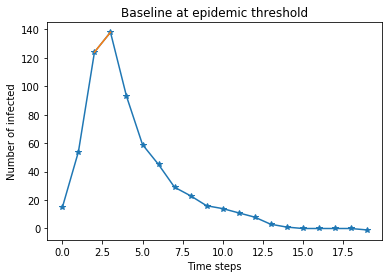

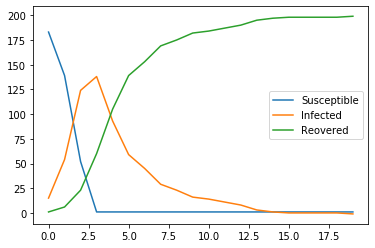

Experiement 3.2

Max infected: 38
Peak starts at timestep: 19
Peak end at timestep: 22


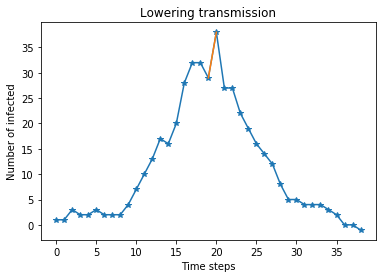

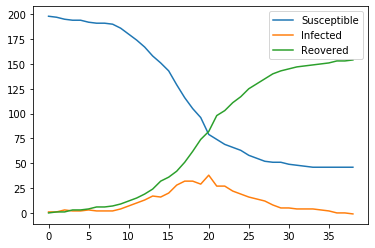

Experiement 3.3

Max infected: 18
Peak starts at timestep: 13
Peak end at timestep: 16


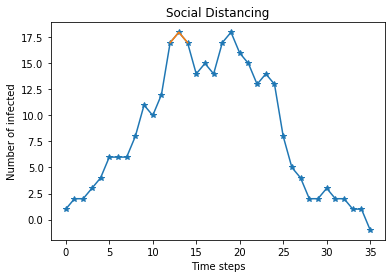

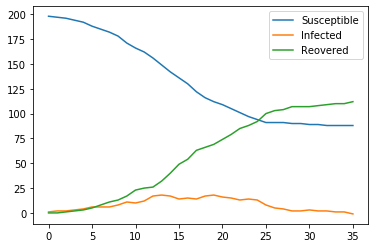

In [215]:
def run_find_peak(n, c, beta, gamma, plot_title):
    #Create random graph
    p = c/(n-1)
    G = nx.gnp_random_graph(n,p)

    flag = 0
    #run simulation
    ST,IT,RT,XT = run_SIR(G,2,beta,gmma,flag)
    
    #find max infected number
    mIT = max(IT)
    #print that out
    print(f'Max infected: {mIT}')
    
    #find max+- threshold
    #this is my definition of how long the peak lasts
    #if infected within 10% of max it is in its peak
    threshold = mIT - (mIT * 0.10)
    set_start = -1
    start_idx = 0
    end_idx = 0
    for i in range(0, IT.index(mIT)):
        if(IT[i] > threshold and IT[i] < mIT):
            print(f'Peak starts at timestep: {i+1}')
            set_start = 1
            start_idx = i
    if(set_start == -1):
        print(f'Peak starts at timestep: {IT.index(mIT) - 1}')
        start_idx = IT.index(mIT) - 1
    for i in range(IT.index(mIT), len(IT)):
        if(IT[i] < threshold):
            print(f'Peak end at timestep: {i+1}')
            end_idx = i
            break
    #plot the infected with the peak that was calculated highlighted
    peak = IT[start_idx:end_idx]
    plt.title(plot_title)
    plt.xlabel("Time steps")
    plt.ylabel("Number of infected")
    plt.plot(range(len(IT)), IT, marker = '*')
    plt.plot(range(start_idx, end_idx), peak)
    plt.show()
    
    #Plot St, It, Rt
    plt.plot(ST, label = "Susceptible")
    plt.plot(IT, label = "Infected")
    plt.plot(RT, label = "Reovered")
    plt.legend()
    plt.show()

#run the three experiments detailed above
print("Experiment 3.1\n")
run_find_peak(200, 6, 0.75, 0.75, "Baseline at epidemic threshold")
print("Experiement 3.2\n")
run_find_peak(200, 6, 0.1, 0.4, "Lowering transmission")
print("Experiement 3.3\n")
run_find_peak(200, 2, 0.5, 0.5, "Social Distancing")

- **What effect does lowering 𝛽 (reducing the likelihood of transmission) have on 𝐼(𝑡), compared to experiment 3.1?**
    - Lowering beta lowers the overall peak of the infection as beta is the probability that you are infected if connected by an edge. Lowering this will lower the number of nodes infected,
- **How much reduced transmission would you need everyone to do to achieve a real "flattening" of the epidemic? Do you think that's realistic?**
    - In order to truly flatten the epimedic you need to lower beta to lower than 0.1 or infecting 10% percent of the people you come in contact with, that touch the same surface as you, or breathe the same air. From the above graph in experiment 3.2 you can see a beta of 0.1 has almost flattened out the infected curve, but it would need to be lower.
- **What effect does lowering 𝑐(reducing the likelihood of transmission) have on 𝐼(𝑡)?, compared to experiment 3.1?** 
    - It halves the peak of the infected nodes. Each node is connected to less nodes meaning less chance for transmission.
- **How much social distancing would you need _everyone_ to do to achieve the results you found in experiment 3.3? (Consider what a typical 𝑐 might be for you during a normal day. Is 𝑐=6 realistic?)**
    - You would need to achieve a crazy social distancing to achieve the results. Interacting with 6 people in an entire day is not realistic for service works, students, professors. These people are interacting with 10s if not 100s of people.
- **Which has a larger effect on 𝐼(𝑡) reduced transmission or social distancing?**
    - Social distancing has a larger effect on I(t) because social distancing lowers beta as well since there is less interactions for transmission.

***
***

## Problem 3 : Reading the literature (*10 pts extra credit*)

Choose a paper from the [Supplemental Reading list on the external course webpage](http://tuvalu.santafe.edu/~aaronc/courses/3352/). Read the paper (the whole paper, not just the abstract). Think about what it says. Then, write 1-3 sentences for each of the following questions in a way that clearly summarizes the work, and its context.
* What paper did you choose?
* What was the research question?
* What was the approach the authors took to answer that question?
* What did they do well?
* What could they have done better?
* What extensions can you envision?


Do not copy any text from the paper itself; write your own summary, in your own words in Markdown in the corresponding box below. Be sure to answer each of the five questions. The amount of extra credit will depend on the accuracy and thoughtfulness of your answers.

Hint: This is a good way to generate some ideas for your class project (your proposal for that is due on **February 27th**. Also, even if you don't understand everything in the paper, that's okay. Do your best to summarize what you did understand.

* *What paper did you choose?*<br/>
Modeling of protein interaction networks
<br/>


* *What was the research question?*<br/>
This paper proposes a model that will help learn the evolutionary dynamics that end up creating protein fucntions and interactions. It is to represet the evolution of protein interaction networks. 
<br/>

* *What was the approach the authors took to answer that question?*<br/>
This paper solely shows how their model can represent the evoluntionary dynamics of protein networks through simulation and calculation. 
<br/>

* *What did they do well?*<br/>
This paper explains protein networks in the beginning to allow the reader to understand more about the problem. This allows us to see a more complete solution. 
<br/>

* *What could they have done better?*<br/>
How does their model compare to other representational models? There is very little to show their ground over other evolutionary models.
<br/>

* *What extensions can you envision?*<br/>
Being able to represent the evolution of proteins can allow us to predict mutations and better protect other people from disease.